In [1]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, maskoceans
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy

In [2]:
nlon = 180
nlat = 90
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89, 91, 2)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

In [97]:
############################################################
### diagnosis of spinup results
### updated with newly defined variable names
############################################################

## Some constants
nyr = 130

##  get and open the restart file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in = 'sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.2000s.spinup.nc'
filename_in = 'extracted.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]
cohort_size_bins = fin.variables['fates_levscls'][:]

## define the sizes of each dimension
ntim = len(time)
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## read in variables
biomass = fin.variables['FATES_CANOPY_VEGC'][:]
area_age = fin.variables['FATES_CANOPYAREA_AP'][:]
landfrac = fin.variables['landfrac'][:]
# hrv_c = fin.variables['HARVEST_CARBON_FLUX'][:]
# hrv_debt = fin.variables['HARVEST_DEBT'][:]
# hrv_flux10c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
# hrv_flux100c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
# sec_frac = fin.variables['SECONDARY_FOREST_FRACTION'][:]

fin.close()

## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_area = fin_luinput.variables['AREA'][:]
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
lu_hrv_frac_vh1 = fin_luinput.variables['HARVEST_VH1'][:]
lu_hrv_frac_vh2 = fin_luinput.variables['HARVEST_VH2'][:]
lu_hrv_frac_sh1 = fin_luinput.variables['HARVEST_SH1'][:]
lu_hrv_frac_sh2 = fin_luinput.variables['HARVEST_SH2'][:]
lu_hrv_frac_sh3 = fin_luinput.variables['HARVEST_SH3'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
nat_area_frac = np.nansum(area_age, 1)
biomass_den = biomass
pft_4x5 = ncvar_pft
lat_4x5 = latnc
lon_4x5 = lonnc
lu_hrv_frac = lu_hrv_frac_vh1+lu_hrv_frac_vh2#+lu_hrv_frac_sh1+lu_hrv_frac_sh2+lu_hrv_frac_sh3
lu_hrv_c = lu_hrv_c_vh1+lu_hrv_c_vh2

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


Text(0.5,1,'Validate spinup biomass')

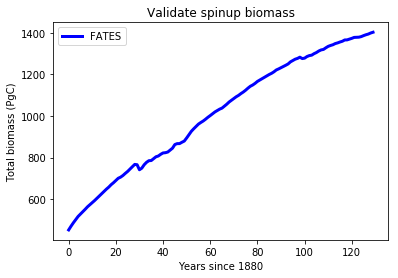

In [98]:
# Validate global total biomass C in Spinup
biomass_fates_day = copy.deepcopy(biomass_den)
biomass_fates_day[biomass_fates_day>100] = np.float('nan')
biomass_fates_yr = np.zeros([130, 46, 72])
for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    biomass_fates_yr[iyr,:,:] = biomass_fates_day[id_end,:,:]*landfrac*area_4x5*nat_area_frac[id_end,:,:]*0.5*1e6
#     hrv_area_lu_yr[iyr,:,:] = lu_hrv_frac[151+iyr,:,:]*area_4x5*nat_area_frac[0,:,:]/1e6

# Mask ocean
biomass_fates_yr[biomass_fates_yr<0] = np.float('nan')

biomass_fates_yr_tot = np.nansum(np.nansum(biomass_fates_yr, 2), 1)/1e12
plt.plot(biomass_fates_yr_tot, 'b-', linewidth=3)
plt.xlabel('Years since 1880')
plt.ylabel('Total biomass (PgC)')
plt.legend(['FATES'])
plt.title('Validate spinup biomass')

In [ ]:
### Plot the secondart forest area from LUH2
### Plot to show number of PFTs and the dominant PFT
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,lu_hrv_c[0,:,:],
              norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale,

cbar = map.colorbar(cs1,ticks=[1e4, 4e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Harvested Primary Forest C, 1851', fontsize=24, color='Black')

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,lu_hrv_c_sec[0,:,:],
              norm=colors.LogNorm(vmin=1e4, vmax=1e8),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1e4, 4e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Harvested Secondary Forest C, 1860', fontsize=24, color='Black')

# plt.show()
plt.savefig('LUH2 harvested C.png')

In [25]:
############################################################
### Examine surface data
### Dominant PFTs, number of PFTs from the surface data
############################################################

## Some constants
nyr = 1

##  get and open the file
filename_in = 'surfdata_4x5_simyr1850_c211105.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
# lon = fin.variables['lsmlon'][:]
# lat = fin.variables['lsmlat'][:]

## read in variables
natveg = fin.variables['PCT_NATVEG'][:]
natpft = fin.variables['PCT_NAT_PFT'][:]

fin.close()

numpft = np.zeros((46,72))
dompft = np.zeros((46,72))
## Calculate numbers of PFTs
for i in np.arange(0,72):
    for j in np.arange(0,46):
        dominant_k = 1
        for k in np.arange(1,16):
            if(natpft[k,j,i] > 0.0):
                numpft[j,i] = numpft[j,i] + 1
            if(natpft[k,j,i]>natpft[dominant_k,j,i]):
                dominant_k = k
                dompft[j,i] = k
            


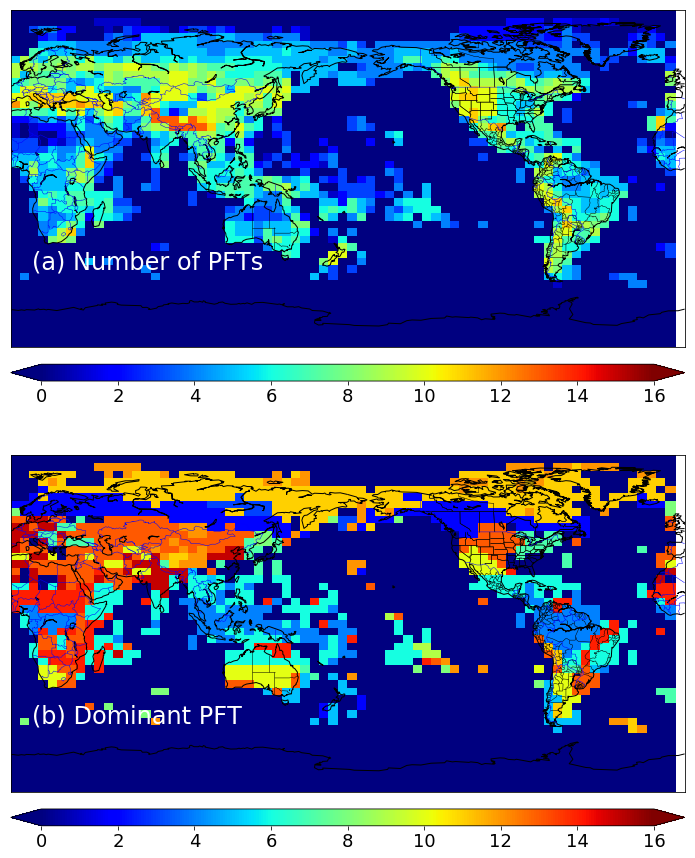

In [26]:
### Plot to show number of PFTs and the dominant PFT
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,numpft[:,:],
              norm=colors.Normalize(vmin=0, vmax=16),cmap=plt.cm.jet) # use log color scale,

cbar = map.colorbar(cs1,ticks=[0, 2, 4, 6, 8, 10, 12, 14, 16],location='bottom',pad="5%",extend='both')
# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Number of PFTs', fontsize=24, color='White')

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,dompft[:,:],
              norm=colors.Normalize(vmin=0, vmax=16),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[0, 2, 4, 6, 8, 10, 12, 14, 16],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Dominant PFT', fontsize=24, color='White')

#plt.show()
plt.savefig('biogeog_map_global_4x5.png')

In [10]:
## Check the biomass from nocomp simulation
## Some constants
nyr = 134

##  get and open the restart file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in = 'sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.2000s.spinup.nc'
filename_in = 'extracted_nocomp_spinup_1850_1983.nc'

fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]

## define the sizes of each dimension
ntim = len(time)
nagebins = len(patch_age_bins)

## read in variables
biomass = fin.variables['FATES_VEGC'][:]
area_age = fin.variables['FATES_PATCHAREA_AP'][:]
landfrac = fin.variables['landfrac'][:]
# hrv_c = fin.variables['HARVEST_CARBON_FLUX'][:]
# hrv_debt = fin.variables['HARVEST_DEBT'][:]
# hrv_flux10c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
# hrv_flux100c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
# sec_frac = fin.variables['SECONDARY_FOREST_FRACTION'][:]

fin.close()

## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_area = fin_luinput.variables['AREA'][:]
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
lu_hrv_frac_vh1 = fin_luinput.variables['HARVEST_VH1'][:]
lu_hrv_frac_vh2 = fin_luinput.variables['HARVEST_VH2'][:]
lu_hrv_frac_sh1 = fin_luinput.variables['HARVEST_SH1'][:]
lu_hrv_frac_sh2 = fin_luinput.variables['HARVEST_SH2'][:]
lu_hrv_frac_sh3 = fin_luinput.variables['HARVEST_SH3'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
nat_area_frac = np.nansum(area_age, 1)
nat_area_frac[nat_area_frac>100] = 0.0
biomass_den = biomass
pft_4x5 = ncvar_pft
lat_4x5 = latnc
lon_4x5 = lonnc
lu_hrv_frac = lu_hrv_frac_vh1+lu_hrv_frac_vh2#+lu_hrv_frac_sh1+lu_hrv_frac_sh2+lu_hrv_frac_sh3
lu_hrv_c = lu_hrv_c_vh1+lu_hrv_c_vh2


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


Text(0.5,1,'Validate spinup biomass')

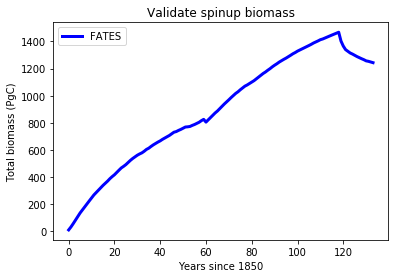

In [13]:
# Validate global total biomass C in Spinup
biomass_fates_day = copy.deepcopy(biomass_den)
biomass_fates_day[biomass_fates_day>100] = np.float('nan')
biomass_fates_yr = np.zeros([134, 46, 72])
for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    biomass_fates_yr[iyr,:,:] = biomass_fates_day[id_end,:,:]*landfrac*area_4x5*nat_area_frac[id_end,:,:]*1e6
#     hrv_area_lu_yr[iyr,:,:] = lu_hrv_frac[151+iyr,:,:]*area_4x5*nat_area_frac[0,:,:]/1e6

# Mask ocean
biomass_fates_yr[biomass_fates_yr<0] = np.float('nan')

biomass_fates_yr_tot = np.nansum(np.nansum(biomass_fates_yr, 2), 1)/1e12
plt.plot(biomass_fates_yr_tot, 'b-', linewidth=3)
plt.xlabel('Years since 1850')
plt.ylabel('Total biomass (PgC)')
plt.legend(['FATES'])
plt.title('Validate spinup biomass')

In [12]:
np.nanmin(nat_area_frac)

0.0

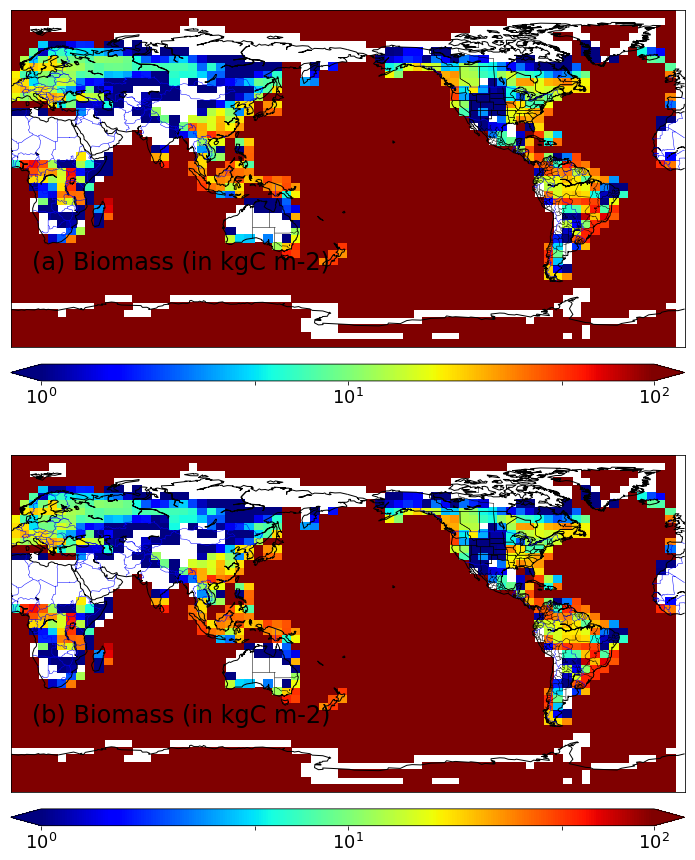

In [9]:
# Biomass map
lonnc_new = copy.deepcopy(lonnc[0,:])
latnc_new = copy.deepcopy(latnc[:,0])

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(211)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')

# Switch longitude extent from 0 - 360 to -180 - 180
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,biomass_den[1607,:,:],
              norm=colors.LogNorm(vmin=1, vmax=1e2),cmap=plt.cm.jet) # use log color scale,
cbar = map.colorbar(cs1,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')

# cs1 = map.pcolormesh(x,y,hrv_debt_sec[100,:,:],
#               norm=colors.LogNorm(vmin=1e4, vmax=1e9),cmap=plt.cm.jet) # use log color scale,
# cbar = map.colorbar(cs1,ticks=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9],location='bottom',pad="5%",extend='both')

# cbar.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.64, '(a) Biomass (in kgC m-2)', fontsize=24)

# Harvest debt map
ax2 = fig.add_subplot(212)
map = Basemap(projection='cyl', llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
map.drawstates()
map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc_new,latnc_new) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)

cs2 = map.pcolormesh(x,y,biomass_den[1601,:,:],
              norm=colors.LogNorm(vmin=1, vmax=1e2),cmap=plt.cm.jet) # use log color scale,

cbar2 = map.colorbar(cs2,ticks=[1, 5, 10, 50, 100],location='bottom',pad="5%",extend='both')
# cbar2.ax.set_xticklabels(['<$10^{-2}$', '$2x10^{-2}$', '$5x10^{-2}$', '$10^{-1}$', '2x$10^{-1}$']) 
cbar2.ax.tick_params(labelsize=18) 

fig.text(0.22, 0.22, '(b) Biomass (in kgC m-2)', fontsize=24)

plt.show()
#plt.savefig('FATES_biomass_hrvdebt_global_map.png')